In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import io
import sys
import json

import numpy as np

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import download_file, clear_download_cache

import matplotlib.pyplot as plt

## Response curves of HSC filters

* For details of HSC filters, please see [this page at NAOJ](https://www.subarutelescope.org/Observing/Instruments/HSC/sensitivity.html)
    * We replace the r-band filter to new one (HSC-r2) from Jul 28th 2016 (HST). We mainly used the previous r-band filter (HSC-r) till Jul 11th 2016 (HST). Please see "FILTER01" at the FITS header for checking which filter was used.
    * We replace the i-band filter to new one (HSC-i2) from Feb 2016. We mainly used the previous i-band filter (HSC-i) till Jan 2016. Please see "FILTER01" at the FITS header for checking which filter was used. 
    * When you estimate a throughput of the Y band filter, you should consider the quantum efficiency of FDCCD, which is very low at >10000 Å.

In [2]:
from unagi import filters
from unagi import camera

In [3]:
# Where we save the filters
filters.FILTER_DIR

'/Users/song/Dropbox/work/project/unagi/unagi/data/filters'

### Basic properties of a HSC filter

# Filter: /Users/song/Dropbox/work/project/unagi/unagi/data/filters/total/hsc_i2_v2018.dat
# Filter type: total
# Version: new
# Effective wavelength   : 7706.070 Angstrom
# Pivot wavelength       : 7733.120 Angstrom
# Mean wavelength        : 7706.070 Angstrom
# Effective width        : 1073.951 Angstrom
# Rectangular width      : 1446.341 Angstrom
# AB absolute magnitude of the sun :  4.518 mag


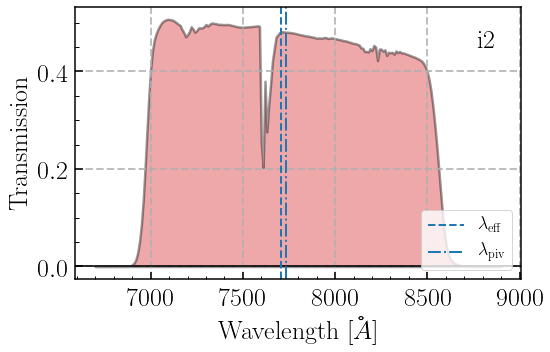

In [5]:
iband = filters.Filter('i2')
iband.print()

# Plot the transmission curves
_ = iband.plot()

### Get a summary table for all filters

In [7]:
# Total transmission curves
hsc_filter_total = filters.hsc_filters(use_saved=False)

# Just the filter; at the center of the camera
hsc_filter_origin_cen = filters.hsc_filters(origin=True, center=True, use_saved=False)

# Just the filter; area weighted
hsc_filter_origin_wgt = filters.hsc_filters(origin=True, center=False, use_saved=False)

### Convert the transmission curve into the Kcorrect format

* This is used by several softwares: e.g. `kcorrect`, `iSEDFit`, `sedpy`

In [9]:
iband.to_kfilter()

### Solar spectrum and the absolute magnitude of the Sun

* By default, we are using the composite Solar spectrum from [Haberreiter et al. 2017](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016JA023492)
    - It is used in [Willmer 2018](https://iopscience.iop.org/article/10.3847/1538-4365/aabfdf)
    - More details can be found [here](http://mips.as.arizona.edu/~cnaw/sun.html)
* We also have the "classic" Kurucz1993 model spectrum

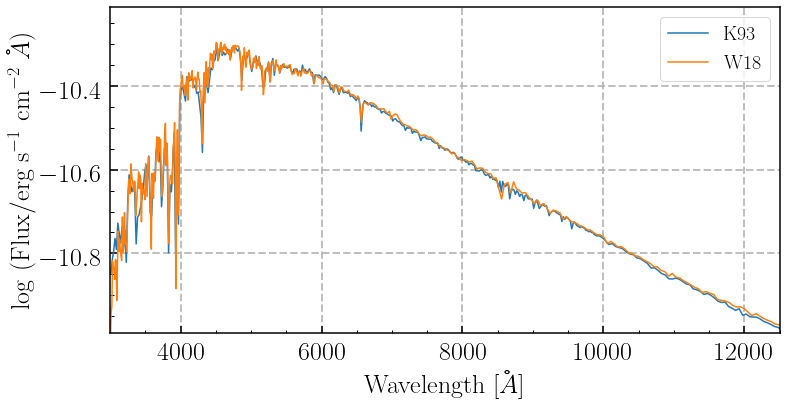

In [10]:
k93 = filters.SolarSpectrum(kind='Kurucz1993')
w18 = filters.SolarSpectrum()

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.8)

ax1.plot(k93.wave, np.log10(k93.flux), label=r'$\rm K93$')
ax1.plot(w18.wave, np.log10(w18.flux), label=r'$\rm W18$')
ax1.legend(loc='best', fontsize=20)
_ = ax1.set_xlim(3000, 12500)
_ = ax1.set_ylim(-10.99, -10.21)
_ = ax1.set_xlabel(r'$\mathrm{Wavelength}\ [\AA]$')
_ = ax1.set_ylabel(r'$\log\ (\mathrm{Flux}/\mathrm{erg\ s^{-1}\ cm^{-2}\ }\AA)$')

### Basic properties of the HSC camera

In [11]:
hsc_cam = camera.Camera()

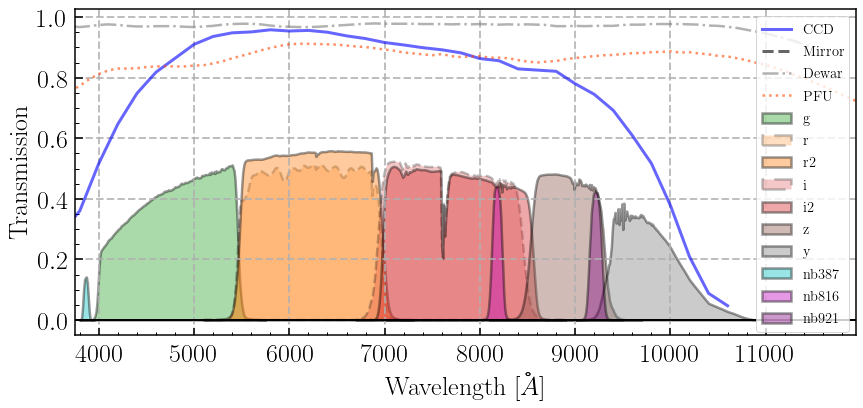

In [17]:
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.8)

# Show the CCD QE
ax1.plot(hsc_cam.qe[:, 0], hsc_cam.qe[:, 1], linewidth=3.0, alpha=0.6, color='b',
         label=r'$\rm CCD$')

# Show the primary mirror reflectivity
ax1.plot(hsc_cam.primary_reflect[:, 0], hsc_cam.primary_reflect[:, 1], 
         linewidth=3.0, alpha=0.6, color='k', linestyle='--',
         label=r'$\rm Mirror$')

# Show the transparency of the dewar window
ax1.plot(hsc_cam.dewar[:, 0], hsc_cam.dewar[:, 1], 
         linewidth=2.5, alpha=0.6, color='gray', linestyle='-.',
         label=r'$\rm Dewar$')

# Show the transparency of the PFU: prime focus unit
ax1.plot(hsc_cam.popt2[:, 0], hsc_cam.popt2[:, 1], 
         linewidth=2.5, alpha=0.6, color='orangered', linestyle=':',
         label=r'$\rm PFU$')

# Overplot all the filters
for filt in hsc_filter_total:
    if filt['short'] == 'r' or filt['short'] == 'i':
        linestyle, alpha = '--', 0.25
    else:
        linestyle, alpha = '-', 0.4
    
    ax1.axhline(0.0, linewidth=2, color='k', alpha=0.8)
    # Filled the transmission curve
    ax1.fill_between(filt['wave'], 0.0, filt['trans'], edgecolor='k', 
                     alpha=alpha, linewidth=2.5, linestyle=linestyle,
                     facecolor=filt['color'], 
                     label=r'$\rm {0}$'.format(filt['short'])) 

ax1.legend(loc='best', fontsize=14.5)

_ = ax1.set_xlim(3750, 11950)
_ = ax1.set_xlabel(r'$\mathrm{Wavelength}\ [\AA]$')
_ = ax1.set_ylabel(r'$\mathrm{Transmission}$')